<h1>Proyecto 1</h1>

In [131]:
import pandas as pd
import nltk
import contractions
import inflect
import re, string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score as AS
from sklearn.metrics import f1_score as F1
from sklearn.metrics import precision_score as PS
from sklearn.metrics import recall_score as RS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import pickle
from datetime import datetime

Se espera que corra en su computador el comando: 
- pip install contractions 
- pip install inflect
- pip install fasttext


<h1>1. Entendimiento y preparación de datos</h1>

In [132]:
ruta = "./data/SuicidiosProyecto.csv"
df = pd.read_csv(ruta, encoding="utf-8", index_col=0)
df.columns

Index(['text', 'class'], dtype='object')

In [133]:
df.sample(5)

,text,class
Unnamed: 0,,
112822,"AP HW Stress Hey guys,\n\nRn I’m in four AP cl...",non-suicide
164831,"look at my meme There is no meme, take off you...",non-suicide
238628,I can’t take it anymoreI don’t know why I’m po...,suicide
174215,Asked a deaf girl out on a date She rejected m...,non-suicide
126846,My dog diedMy dog I had for 20 years. He was s...,suicide


In [134]:
df.dtypes

text     object
class    object
dtype: object

In [135]:
df['class'].value_counts(dropna=False, normalize=True)

non-suicide    0.562928
suicide        0.437072
Name: class, dtype: float64

In [136]:
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [137]:
df['no_constractions'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [138]:
df['text'] = [' '.join(map(str, l)) for l in df['no_constractions']]

In [139]:
df['tokenized'] = df['text'].apply(nltk.word_tokenize)

In [140]:
df['tokenized'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

In [141]:
punc = string.punctuation
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in punc])

In [142]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juliana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
df['tokenized_str'] = [' '.join(map(str,l)) for l in df['tokenized']]
df.head()

,text,class,no_constractions,tokenized,tokenized_str
Unnamed: 0,,,,,
173271,i want to destroy myselffor once everything wa...,suicide,"[i, want, to, destroy, myselffor, once, everyt...","[want, destroy, myselffor, everything, startin...",want destroy myselffor everything starting fee...
336321,I kind of got behind schedule with learning fo...,non-suicide,"[I, kind of, got, behind, schedule, with, lear...","[kind, got, behind, schedule, learning, next, ...",kind got behind schedule learning next week te...
256637,I am just not sure anymoreFirst and foremost: ...,suicide,"[I am, just, not, sure, anymoreFirst, and, for...","[sure, anymorefirst, foremost, brazil, judge, ...",sure anymorefirst foremost brazil judge second...
303772,please give me a reason to liveThats too much ...,suicide,"[please, give, me, a, reason, to, liveThats, t...","[please, give, reason, livethats, much, reason...",please give reason livethats much reason live ...
293747,27f struggling to find meaning moving forwardI...,suicide,"[27f, struggling, to, find, meaning, moving, f...","[27f, struggling, find, meaning, moving, forwa...",27f struggling find meaning moving forwardi ad...


In [144]:
df.sample(5)

,text,class,no_constractions,tokenized,tokenized_str
Unnamed: 0,,,,,
320811,Is there any logical reason NOT to commit suic...,suicide,"[Is, there, any, logical, reason, NOT, to, com...","[logical, reason, commit, suicide, owe, money,...",logical reason commit suicide owe money school...
336707,I have everything I ever wanted and I am still...,suicide,"[I, have, everything, I, ever, wanted, and, I ...","[everything, ever, wanted, still, ok., funnnnn...",everything ever wanted still ok. funnnnni 'm c...
282389,"Pain,sorrow,guilt?My parents both died a year ...",suicide,"[Pain,sorrow,guilt?My, parents, both, died, a,...","[pain, sorrow, guilt, parents, died, year, apa...",pain sorrow guilt parents died year apart two ...
111947,A shot for shot remake of the Drivers License ...,non-suicide,"[A, shot, for, shot, remake, of, the, Drivers,...","[shot, shot, remake, drivers, license, video, ...",shot shot remake drivers license video singer ...
73625,13 year olds. Do you agree? Do you agree that ...,non-suicide,"[13, year, olds., Do, you, agree?, Do, you, ag...","[13, year, olds, agree, agree, frogs, best]",13 year olds agree agree frogs best


In [145]:
x_train, x_test, y_train, y_test = train_test_split(df['tokenized_str'], df['class'], test_size=0.3, random_state=28)

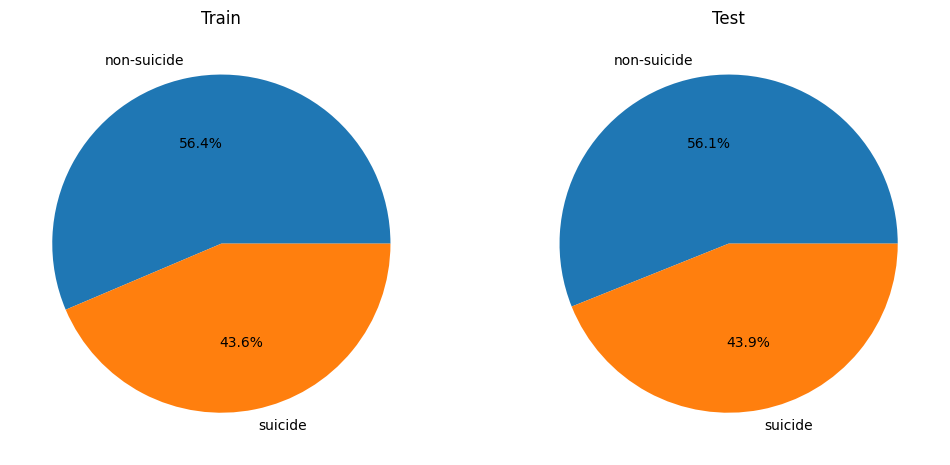

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%')
ax[0].set_title('Train')
ax[1].pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%')
ax[1].set_title('Test')
plt.show()

In [147]:
bow = CountVectorizer(tokenizer = nltk.word_tokenize)
x_train_bow = bow.fit_transform(x_train)
x_test_bow = bow.transform(x_test)
len(bow.get_feature_names())

c:\Users\Juliana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


155565

<h3>Random forest usando BoW</h3>

In [148]:
bow_model = RandomForestClassifier(random_state = 2)

In [149]:
bow_model.fit(x_train_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot: >

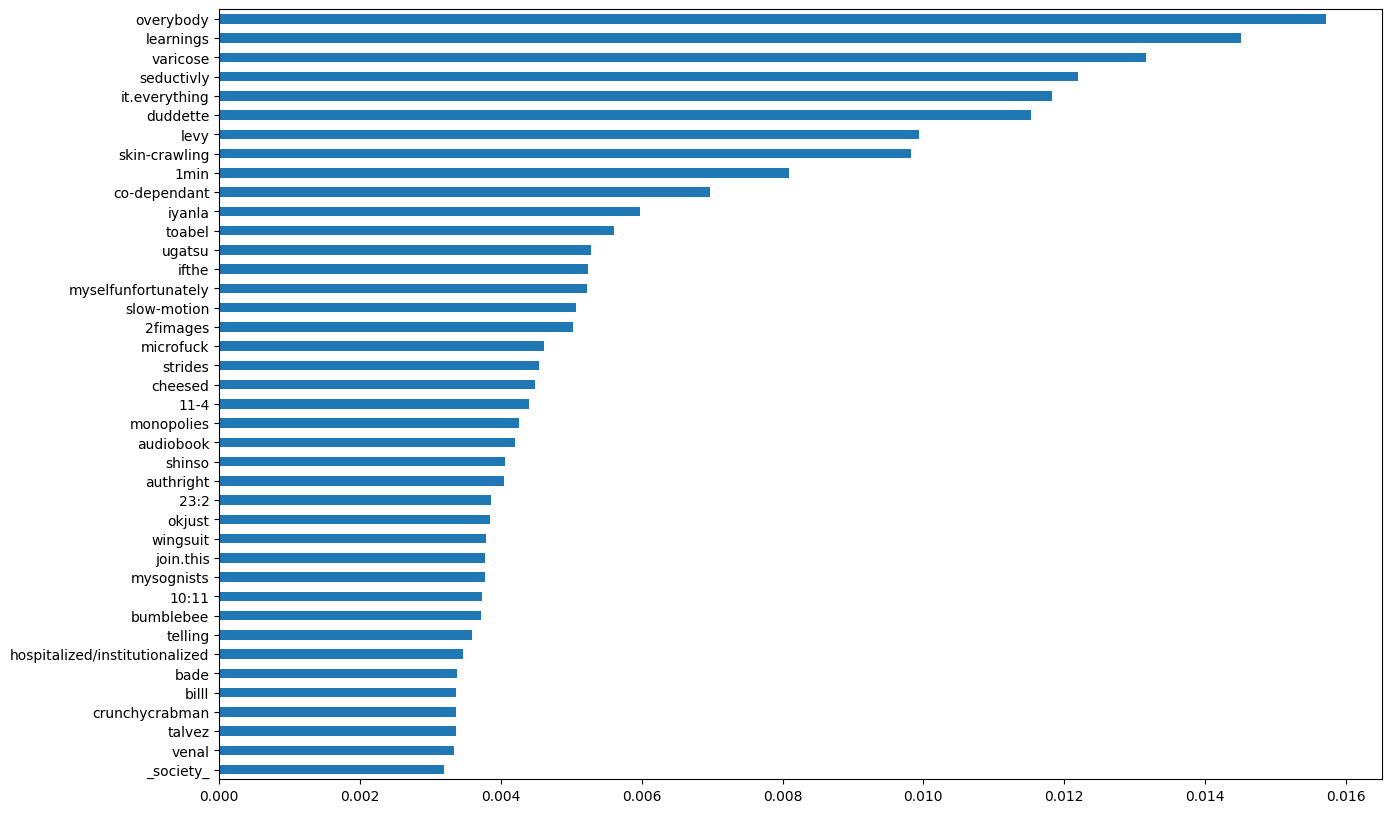

In [150]:
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(40).plot.barh(figsize = (15, 10))

In [151]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 1738.77


In [152]:
y_train_bow_predict = bow_model.predict(x_train_bow)
y_test_bow_predict = bow_model.predict(bow.transform(x_test))

In [153]:
cm_train = confusion_matrix(y_train, y_train_bow_predict)
cm_test = confusion_matrix(y_test, y_test_bow_predict)
cm_train_norm = confusion_matrix(y_train, y_train_bow_predict, normalize='true')
cm_test_norm = confusion_matrix(y_test, y_test_bow_predict, normalize='true')

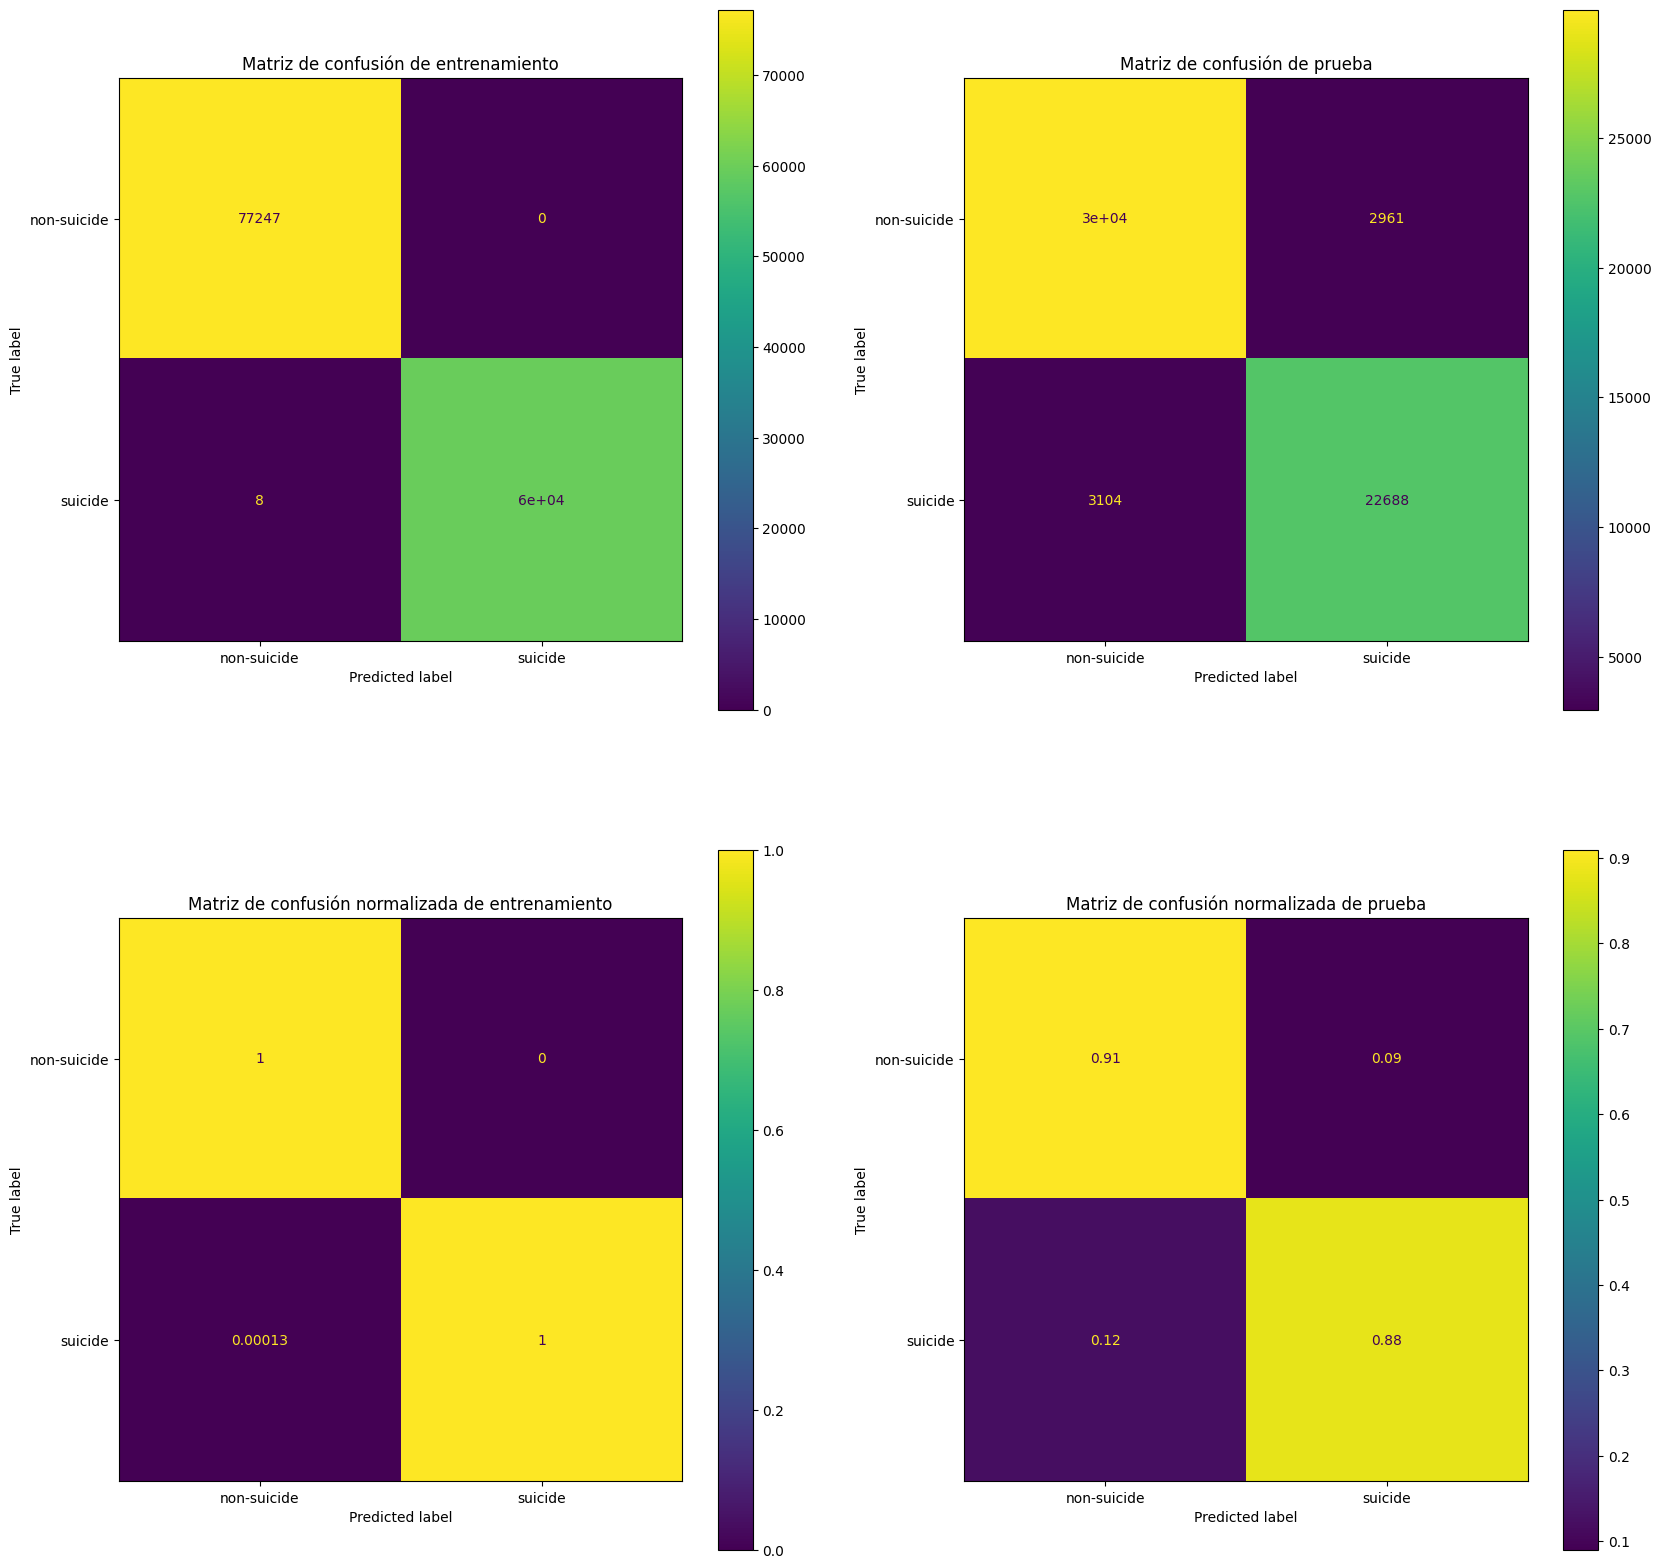

In [164]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax[0, 0].set_title('Matriz de confusión de entrenamiento')
ax[0, 1].set_title('Matriz de confusión de prueba')
ax[1, 0].set_title('Matriz de confusión normalizada de entrenamiento')
ax[1, 1].set_title('Matriz de confusión normalizada de prueba')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=bow_model.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=bow_model.classes_)
disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm, display_labels=bow_model.classes_)
disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=bow_model.classes_)
disp_train.plot(ax=ax[0, 0])
disp_test.plot(ax=ax[0, 1])
disp_train_norm.plot(ax=ax[1, 0])
disp_test_norm.plot(ax=ax[1, 1])
plt.show()

In [155]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 1.0
Recall: 0.9998660930987731
F1: 0.9999330420663218


In [156]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8845569028032282
Recall: 0.8796526054590571
F1: 0.8820979374428957


In [157]:
now = datetime.now()
date = now.date()
time = now.time().strftime("%H-%M-%S")

In [158]:
nombre="modelo_dia_"+str(date)+"_hora_"+str(time)+".pkl"
pickle.dump(bow_model,open(nombre,"wb"))